## This notebook contains pieces of code which is used to generate figures.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm, TwoSlopeNorm
import os

import astropy.io.fits as fits
import hcipy

from pastis.simulators.scda_telescopes import HexRingAPLC
from pastis.util import sort_1d_mus_per_actuator
import pastis.util as util
from pastis.config import CONFIG_PASTIS
os.chdir('../ULTRA')
from config import CONFIG_ULTRA

#### Create data directory

In [2]:
data_dir = CONFIG_PASTIS.get('local', 'local_data_path')
resDir = util.create_data_path(data_dir, 'figures')
os.makedirs(resDir, exist_ok=True)


/Users/asahoo/Desktop/data_repos/harris_data



## Generate optical schematics for a telescope simulator

#### For SCDA Designs

In [ ]:
optics_dir = os.path.join(util.find_repo_location(), 'data', 'SCDA')
NUM_RINGS = 5
sampling = 4

tel = HexRingAPLC(optics_dir, NUM_RINGS, sampling)
psf, intermediates = tel.calc_psf(display_intermediate=False, 
                                  return_intermediate='intensity',
                                  norm_one_photon=True)

### Plot intensities are various intermediate planes

In [ ]:
fpm_mask = np.zeros(len(intermediates['after_fpm']))

for i in range(0, len(intermediates['after_fpm'])):
    if intermediates['after_fpm'][i] == 0.0:
        fpm_mask[i] = 0
    else:
        fpm_mask[i] = 1

In [ ]:
plt.figure(figsize = (10, 7))

# Entrance Pupil
plt.subplot(2, 3, 1)
hcipy.imshow_field(tel.apodizer, mask = tel.aperture, cmap='Greys_r')
plt.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
#plt.colorbar()


# before FPM
plt.subplot(2, 3, 2)
hcipy.imshow_field(intermediates['before_fpm'], 
                   norm=LogNorm(vmin=1e-8, vmax=1e-1), cmap='inferno')
plt.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
#plt.colorbar()

# after FPM, note: calc_psf returns int_after_fpm in log scale.
plt.subplot(2, 3, 3)
hcipy.imshow_field(10**(intermediates['after_fpm']), 
                   norm=LogNorm(vmin=1e-8, vmax=1e-1),mask = fpm_mask,cmap= 'inferno')
plt.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
#plt.colorbar()


# before Lyot Stop
plt.subplot(2, 3, 4)
hcipy.imshow_field(intermediates['before_lyot'], norm=LogNorm(vmin=1e-3, vmax=1), 
                   cmap='inferno')
plt.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
#plt.colorbar()

# after Lyot Stop
plt.subplot(2, 3, 5)
hcipy.imshow_field(intermediates['after_lyot'], mask=tel.lyotstop, norm=LogNorm(vmin=1e-3, vmax=1),
                   cmap='inferno')
plt.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
#plt.colorbar()

# final PSF
plt.subplot(2, 3, 6)
hcipy.imshow_field(psf, norm=LogNorm(vmin=1e-14, vmax=1e-3), cmap='inferno')
plt.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
#plt.colorbar()

plt.tight_layout()
plt.savefig(os.path.join(resDir, f'optical_train_{NUM_RINGS}_rings.png'))






# Generate pm/s surface maps 


### Get necessary data files / initialize variables.

In [34]:
#Check the NUM_RINGS for the following data path.
NUM_RINGS = 1

local_data_path = CONFIG_ULTRA.get('local_path', 'local_data_path')
mus_csv_data_path = os.path.join(local_data_path, '2023-10-02T17-18-48_hexringtelescope/mus_Hex_1_1e-11.csv') 

optimal_wavescale = 35      # get this value from mus_csv_data_path folder
fractional_scale = 0.0001 

mus = np.genfromtxt(mus_csv_data_path, delimiter=',')

In [35]:
optics_dir = os.path.join(util.find_repo_location(), 'data', 'SCDA')
sampling = 4
tel = HexRingAPLC(optics_dir, NUM_RINGS, sampling)

WHICH_DM = 'harris_seg_mirror'

if WHICH_DM == 'harris_seg_mirror':
    fpath = CONFIG_PASTIS.get('LUVOIR', 'harris_data_path')  # path to Harris spreadsheet
    pad_orientations = np.pi / 2 * np.ones(CONFIG_PASTIS.getint('LUVOIR', 'nb_subapertures'))
    DM_SPEC = (fpath, pad_orientations, True, False, False)
    NUM_MODES = 5
    
tel.create_segmented_harris_mirror(fpath, pad_orientations, thermal=True, mechanical=False, other=False)

mus_per_actuator = sort_1d_mus_per_actuator(mus, NUM_MODES, tel.nseg)  # in nm

mu_maps = []

for mode in range(NUM_MODES):
    coeffs = mus_per_actuator[mode]
    if WHICH_DM == 'harris_seg_mirror':
        tel.harris_sm.actuators = coeffs * 1e-9 / 2  # in meters of surface
        mu_maps.append(tel.harris_sm.surface)  # in m
    if WHICH_DM == 'seg_mirror':
        tel.sm.actuators = coeffs * 1e-9 / 2  # in meters of surface
        mu_maps.append(tel.sm.surface)  # in m

/opt/miniconda3/envs/ultra-pastis/lib/python3.10/site-packages/hcipy/field/cartesian_grid.py:74: UserWarning: No automatic weights could be calculated for this grid.
  self.weights *= np.abs(scale)**self.ndim


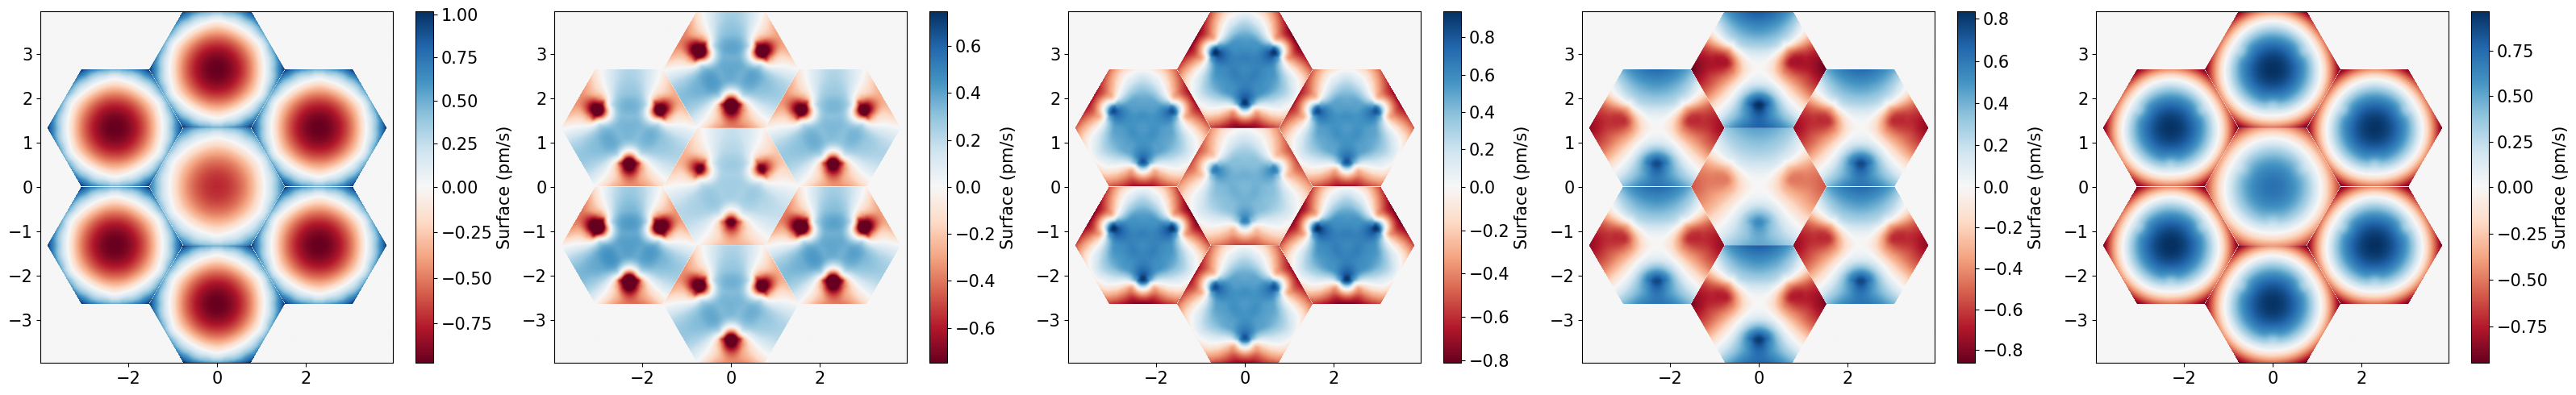

In [36]:
plt.figure(figsize=(32, 5))
plt.subplot(1, 5, 1)
#plot_norm = TwoSlopeNorm(vcenter=0, vmin=-5, vmax=5)
plot_norm = TwoSlopeNorm(vcenter=0)
hcipy.imshow_field((mu_maps[0]) * 1e12 * np.sqrt(fractional_scale * optimal_wavescale ** 2), norm=plot_norm, cmap='RdBu')
plt.tick_params(top=False, bottom=True, left=True, right=False, labelleft=True, labelbottom=True, labelsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label("Surface (pm/s)", fontsize=15)
plt.tight_layout()

plt.subplot(1, 5, 2)
#plot_norm = TwoSlopeNorm(vcenter=0, vmin=-10, vmax=10)
plot_norm = TwoSlopeNorm(vcenter=0, vmin=-0.75, vmax=0.75)
hcipy.imshow_field((mu_maps[1]) * 1e12 * np.sqrt(fractional_scale * optimal_wavescale ** 2), norm=plot_norm, cmap='RdBu')
plt.tick_params(top=False, bottom=True, left=True, right=False, labelleft=True, labelbottom=True, labelsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label("Surface (pm/s)", fontsize=15)
plt.tight_layout()

plt.subplot(1, 5, 3)
#plot_norm = TwoSlopeNorm(vcenter=0, vmin=-8, vmax=8)
plot_norm = TwoSlopeNorm(vcenter=0)
hcipy.imshow_field((mu_maps[2]) * 1e12 * np.sqrt(fractional_scale * optimal_wavescale ** 2), norm=plot_norm, cmap='RdBu')
plt.tick_params(top=False, bottom=True, left=True, right=False, labelleft=True, labelbottom=True, labelsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label("Surface (pm/s)", fontsize=15)
plt.tight_layout()

plt.subplot(1, 5, 4)
#plot_norm = TwoSlopeNorm(vcenter=0, vmin=-7, vmax=7)
plot_norm = TwoSlopeNorm(vcenter=0)
hcipy.imshow_field((mu_maps[3]) * 1e12 * np.sqrt(fractional_scale * optimal_wavescale ** 2), norm=plot_norm, cmap='RdBu')
plt.tick_params(top=False, bottom=True, left=True, right=False, labelleft=True, labelbottom=True, labelsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label("Surface (pm/s)", fontsize=15)
plt.tight_layout()

plt.subplot(1, 5, 5)
#plot_norm = TwoSlopeNorm(vcenter=0, vmin=-12, vmax=12)
plot_norm = TwoSlopeNorm(vcenter=0)
hcipy.imshow_field((mu_maps[4]) * 1e12 * np.sqrt(fractional_scale * optimal_wavescale ** 2), norm=plot_norm, cmap='RdBu')
plt.tick_params(top=False, bottom=True, left=True, right=False, labelleft=True, labelbottom=True, labelsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label("Surface (pm/s)", fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(resDir, f'surface_pm_s_{NUM_RINGS}.png'))

# Plot contrast vs t_exp, for different scda designs.  

In [ ]:
# Bring all the analysis run for all scda designs to a common folder, give the path to 'data_path'

data_path = CO
hex1_data = '2023-10-02T17-18-48_hexringtelescope'
hex2_data = '2023-10-03T14-03-30_hexringtelescope'
hex3_data = '2023-10-03T15-43-44_hexringtelescope'
hex4_data = '2023-10-03T16-24-08_hexringtelescope'
hex5_data = '2023-10-03T16-48-52_hexringtelescope'

TimeMinus = CONFIG_ULTRA.getfloat('close_loop', 'TimeMinus')
TimePlus = CONFIG_ULTRA.getfloat('close_loop', 'TimePlus')
Ntimes = CONFIG_ULTRA.getint('close_loop', 'Ntimes')

texp = np.logspace(TimeMinus, TimePlus, Ntimes)

C_TARGET = CONFIG_ULTRA.getfloat('target', 'contrast')
Vmag = CONFIG_ULTRA.getfloat('target', 'Vmag')
    
hex1 = np.genfromtxt(os.path.join(data_path, hex1_data,'contrast_wf.csv'), delimiter=',')
hex2 = np.genfromtxt(os.path.join(data_path, hex2_data,'contrast_wf.csv'), delimiter=',')
hex3 = np.genfromtxt(os.path.join(data_path, hex3_data,'contrast_wf.csv'), delimiter=',')
hex4 = np.genfromtxt(os.path.join(data_path, hex4_data,'contrast_wf.csv'), delimiter=',')
hex5 = np.genfromtxt(os.path.join(data_path, hex5_data,'contrast_wf.csv'), delimiter=',')

contrast_floor1 = 5.40e-11
contrast_floor2 = 4.17e-11
contrast_floor3 = 6.26e-11
contrast_floor4 = 8.90e-11
contrast_floor5 = 3.98e-11

plt.figure(figsize=(15, 10))

font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 20}
plt.title('Target contrast = %s, Vmag= %s' % (C_TARGET, Vmag), fontdict=font)

#see config and tolerance table to know the optimal wavescale and accrodingly chose part of the hex data array.  
plt.plot(texp, hex1[5 * Ntimes:(5 + 1) * Ntimes] - contrast_floor1, 
         label=r'1Hex, $ Q = % .2f\ pm/s$' % (0.7841)) 
plt.plot(texp, hex2[0 * Ntimes:(0 + 1) * Ntimes]  - contrast_floor2, 
         label=r'2Hex, $ Q = % .2f\ pm/s$' % (0.5241))
plt.plot(texp, hex3[0 * Ntimes:(0 + 1) * Ntimes] - contrast_floor3, 
         label=r'3Hex, $ Q = % .2f\ pm/s$' % (0.5556))
plt.plot(texp, hex4[0 * Ntimes:(0 + 1) * Ntimes] - contrast_floor4, 
         label=r'4Hex, $ Q = % .2f\ pm/s$' % (0.6457))
plt.plot(texp, hex5[0 * Ntimes:(0 + 1) * Ntimes] - contrast_floor5, 
         label=r'5Hex, $ Q= % .2f\ pm/s$' % (0.9226))


plt.xlabel("$t_{WFS}$ in secs", fontsize=20)
plt.ylabel(r"$ \Delta $ contrast", fontsize=20)
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper center', fontsize=20)
plt.tick_params(top=True, bottom=True, left=True, right=True, labelleft=True, labelbottom=True, labelsize=20)
plt.tick_params(axis='both', which='major', length=10, width=2)
plt.tick_params(axis='both', which='minor', length=6, width=2)
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(resDir, f'temporal_designs.png'))